# Exploratory Text Analysis: Project Modeling

**Student:** Ian Yung  
**Class:** DS 5001

---

## Introduction

Welcome to my exploratory text analysis project! In this notebook, I'll be developing models using the previously loaded data.

---

## Table of Contents

1. [Introduction](#Introduction)
2. [Load Data](#Load-Data)
3. [PCA](#PCA)
4. [Visualizations](#Visualizations)
5. [LDA](#LDA)
6. [THETA](#THETA)
7. [PHI](#PHI)
8. [TOPICS](#TOPICS)
9. [PCA Visualizations](#PCA-Visualizations)
10. [Sentiment Analysis](#Sentiment-Analysis)
11. [Word Embedding](#Word-Embedding)
12. [TSNE Plot](#TSNE-Plot)
13. [RIFFS](#Riffs)


Feel free to navigate through the sections using the links provided above.


In [1]:
import pandas as pd
import numpy as np
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import plotly_express as px
import seaborn as sns
from IPython.display import display, HTML

import re

import nltk
from nltk import pos_tag

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import gensim
from scipy.linalg import norm, eigh
from gensim.corpora import Dictionary
from gensim.models import LdaModel, word2vec
from sklearn.manifold import TSNE as tsne

# Load Data

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [3]:
CORPUS = pd.read_csv("data/CORPUS.csv")
VOCAB = pd.read_csv("data/VOCAB_imp.csv")
LIB = pd.read_csv("data/LIB.csv")
BOW = pd.read_csv("data/BOW.csv")
CORPUS.set_index(OHCO, inplace=True)
VOCAB.set_index('term_str', inplace=True)
LIB.set_index('book_id', inplace=True)
BOW.set_index(['book_id', 'chap_num', 'term_str'], inplace=True)

In [4]:
VOCAB_imp = VOCAB

# PCA

In [5]:
# For CMAP !!!
colors = "YlGnBu" 

In [6]:
VOCAB

n  n_chars             p          i max_pos max_pos_group  stop  \
term_str                                                                      
0           1        1  7.819006e-07  20.286512      CD            CD     0   
1         135        1  1.055566e-04  13.209696      CD            CD     0   
10         54        2  4.222263e-05  14.531624      CD            CD     0   
100         8        3  6.255205e-06  17.286512      CD            CD     0   
10022       1        5  7.819006e-07  20.286512      CD            CD     0   
...       ...      ...           ...        ...     ...           ...   ...   
þa          1        2  7.819006e-07  20.286512     NNP            NN     0   
þisses      1        6  7.819006e-07  20.286512     VBZ            VB     0   
þunor       1        5  7.819006e-07  20.286512     NNP            NN     0   
þá          1        2  7.819006e-07  20.286512     NNP            NN     0   
þórr        1        4  7.819006e-07  20.286512     NNP            NN     0   

         porter_stem       dfidf  
term_str                          
0                  0    7.857981  
1                  1  121.775420  
10                10   66.385008  
100              100   27.680265  
10022          10022    7.857981  
...              ...         ...  
þa                þa    7.857981  
þisses          þiss    7.857981  
þunor          þunor    7.857981  
þá                þá    7.857981  
þórr            þórr    7.857981  

[23593 rows x 9 columns]

In [7]:
TFIDF = BOW['tfidf'].unstack(fill_value=0)
pos_set = ['NN', 'VB']
VSHORT = VOCAB[VOCAB.max_pos_group.isin(['NN', 'VB', 'JJ']) & ~VOCAB.max_pos.isin(['NNP'])].sort_values('dfidf', ascending=False).head(5000)
TFIDF = TFIDF[VSHORT.index]

In [8]:
def create_pca(TFIDF):
    TFIDF_L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

    a = len(TFIDF_L2)
    TFIDF_L2 = TFIDF_L2.dropna()
    b = len(TFIDF_L2)
    bag_loss = a - b
    TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()
    COV = TFIDF_L2.cov() # This also centers the vectors

    # create eigenvalues
    eig_vals, eig_vecs = eigh(COV)
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    
    # create COMPS
    EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
    EIG_VEC_PAIRS.index.names = ['term1', 'term2']
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'

    # generate DCM
    DCM = TFIDF_L2.dot(COMPS[COV.index].T)

    # generate LOADINGS
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'

    return COMPS, DCM, LOADINGS

In [9]:
COMPS, DCM, LOADINGS = create_pca(TFIDF)

In [10]:
COMPS

eig_val     watch     swift      bare    raised    listen      sign  \
pc_id                                                                         
PC0    0.043267 -0.009959 -0.023373 -0.001225 -0.003215  0.002946 -0.007977   
PC1    0.029884 -0.016945 -0.018409 -0.010099 -0.001879 -0.005502 -0.022580   
PC2    0.028358  0.006268  0.005641  0.005898 -0.005715 -0.006110  0.009108   
PC3    0.022058 -0.011106 -0.022193  0.006542 -0.012450 -0.002463  0.002465   
PC4    0.017138  0.007256 -0.003575 -0.002244 -0.008383 -0.000270  0.013901   
PC5    0.015935 -0.007422 -0.005261 -0.019154 -0.010179 -0.001174 -0.009071   
PC6    0.011408  0.013218 -0.008046 -0.005994 -0.009095 -0.006156  0.007688   
PC7    0.010617  0.000752 -0.011282 -0.021265  0.001330  0.001741 -0.005836   
PC8    0.010445 -0.009545  0.002701 -0.003845 -0.021604  0.013889 -0.003054   
PC9    0.009734 -0.024640  0.013641  0.004740 -0.004536 -0.000200 -0.001807   

        enemies      wise    likely  ...   trained    fathom   escapes  \
pc_id                                ...                                 
PC0   -0.002112 -0.023210  0.009478  ...  0.002665 -0.001491 -0.002813   
PC1   -0.013549 -0.008538 -0.004950  ... -0.000871  0.000619  0.002097   
PC2   -0.001826  0.004701  0.006378  ...  0.002503  0.000057  0.001867   
PC3   -0.016944 -0.018896 -0.004198  ... -0.000336  0.002409  0.001690   
PC4   -0.003149 -0.000279  0.001358  ... -0.003807  0.000123  0.007508   
PC5   -0.006108  0.003537 -0.008384  ... -0.003430 -0.004764 -0.000061   
PC6   -0.015173  0.023781 -0.008032  ... -0.006717 -0.002583  0.004613   
PC7    0.011293 -0.008267  0.002968  ... -0.004614  0.001598 -0.000344   
PC8   -0.008195  0.014427  0.023301  ...  0.012912 -0.001193  0.004742   
PC9    0.001723 -0.007965  0.006766  ... -0.000314 -0.007022 -0.000339   

            vow  impatience   shocked     fares  anchored    joints  exp_var  
pc_id                                                                         
PC0   -0.009632    0.000775  0.004474 -0.006316 -0.005004  0.001220     4.84  
PC1   -0.001447    0.001130  0.000088  0.009882  0.006439 -0.002072     3.35  
PC2   -0.000019    0.000548  0.001141 -0.001688  0.001168  0.003398     3.17  
PC3   -0.011945    0.001825  0.004264  0.007356 -0.003651 -0.001487     2.47  
PC4   -0.011048   -0.004064 -0.007371  0.005690 -0.002956 -0.000018     1.92  
PC5    0.003286    0.003444 -0.003081 -0.005743  0.000050 -0.003086     1.78  
PC6   -0.000470   -0.002102 -0.001812 -0.000641  0.004916 -0.000814     1.28  
PC7    0.002014    0.002370 -0.009008 -0.000684 -0.006857  0.002586     1.19  
PC8   -0.005626    0.011722  0.020711 -0.002319 -0.004673  0.000481     1.17  
PC9   -0.003229   -0.021374 -0.008511  0.001674  0.000251 -0.009560     1.09  

[10 rows x 5002 columns]

In [11]:
COMPS.iloc[0].nlargest(6).index

Index(['exp_var', 'caspian', 'tirian', 'stable', 'everyone', 'wardrobe'], dtype='object')

In [12]:
COMPS.iloc[0].nsmallest(6).index

Index(['p', 'elves', 'tale', 'dwelt', 'named', 'forth'], dtype='object')

In [13]:
DCM

pc_id                  PC0       PC1       PC2       PC3       PC4       PC5  \
book_id chap_num                                                               
1       0         0.051108 -0.180648  0.050614  0.142801  0.139632 -0.004089   
        1        -0.092131 -0.189946  0.053606  0.020693  0.110249 -0.052716   
        2        -0.068386 -0.257890  0.074920  0.060333  0.158517 -0.171303   
        3         0.045914 -0.187854  0.028506  0.077148  0.089443 -0.115935   
        4         0.011903 -0.185592  0.053183  0.089469  0.136963 -0.106993   
...                    ...       ...       ...       ...       ...       ...   
14      12        0.272563  0.061182 -0.648570 -0.217273  0.127943 -0.020551   
        13        0.311795  0.066332 -0.687444 -0.199624  0.139956 -0.027091   
        14        0.147981 -0.000673 -0.158843 -0.000459 -0.025401 -0.026163   
        15        0.048034  0.049059 -0.123445 -0.004925 -0.115211  0.017789   
        16        0.254873  0.075871 -0.426563 -0.134299  0.070518 -0.032209   

pc_id                  PC6       PC7       PC8       PC9  
book_id chap_num                                          
1       0         0.217919  0.022330  0.269594 -0.044589  
        1         0.225921  0.021656  0.176037 -0.148196  
        2         0.257879 -0.078155  0.094518  0.098777  
        3         0.087557 -0.064318  0.068852  0.126148  
        4         0.120928 -0.031477  0.127776  0.063876  
...                    ...       ...       ...       ...  
14      12        0.020311  0.054581 -0.005157  0.012205  
        13        0.072160  0.025103 -0.005761 -0.011448  
        14       -0.036824 -0.118776 -0.153609  0.063507  
        15       -0.044144 -0.015740  0.045974 -0.065920  
        16        0.043844 -0.083959 -0.059781  0.032304  

[232 rows x 10 columns]

# Visualizations

In [14]:
def vis_pcs(M, a, b, label='author', hover_name='doc', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

def vis_loadings(a=0, b=1, hover_name='term_str'):
    # X = LOADINGS.join(VOCAB)
    X = LOADINGS.join(VSHORT)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos_group', 
                      marginal_x='box', height=800)

### First two components

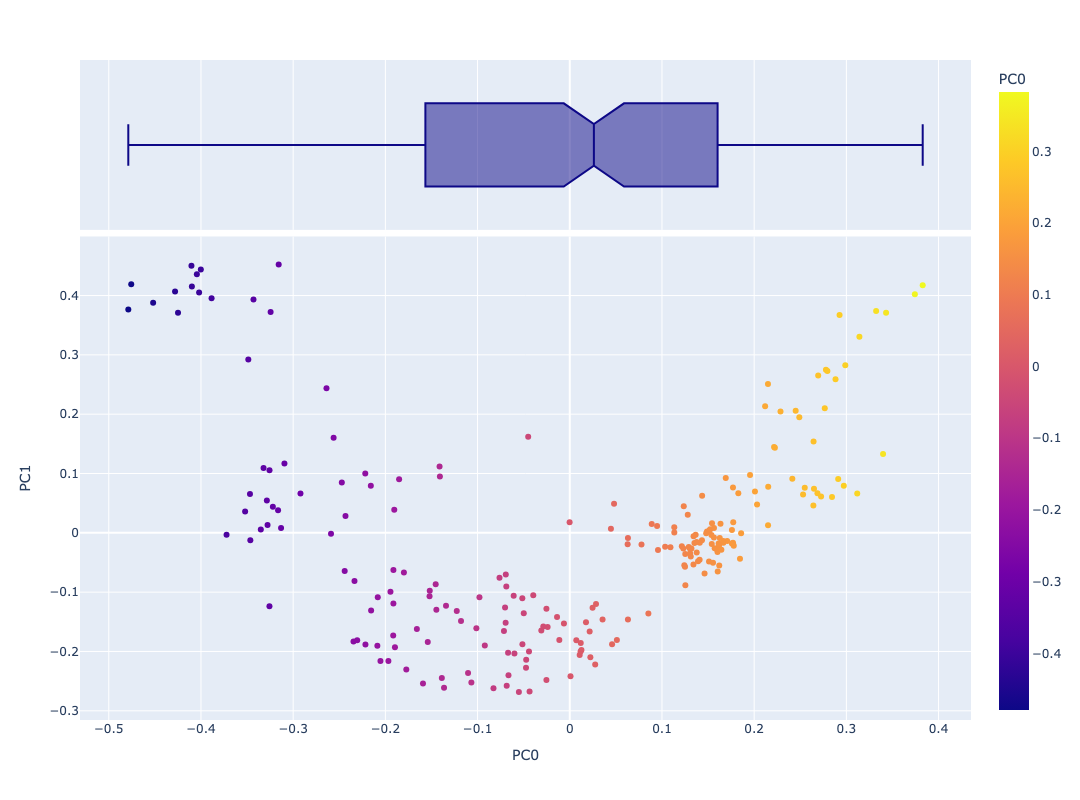

In [15]:
# after amending the DCM to include LIB values, change label back to default
vis_pcs(DCM, 0, 1, label="PC0", hover_name="PC0")

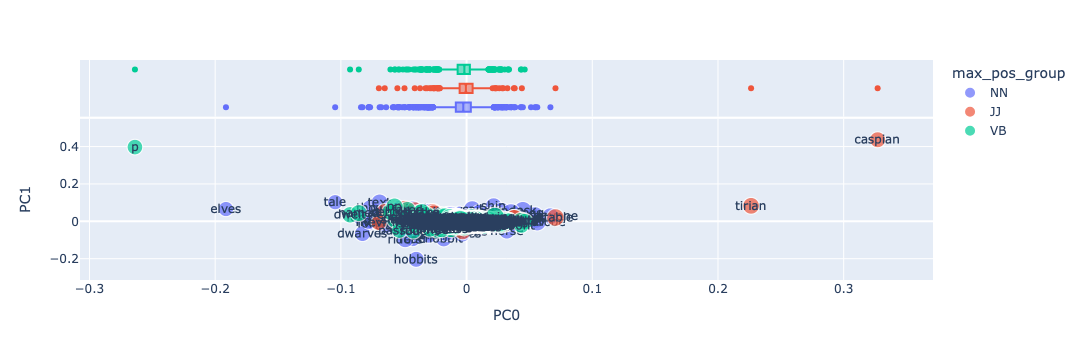

In [16]:
vis_loadings(0,1)

### Next two components

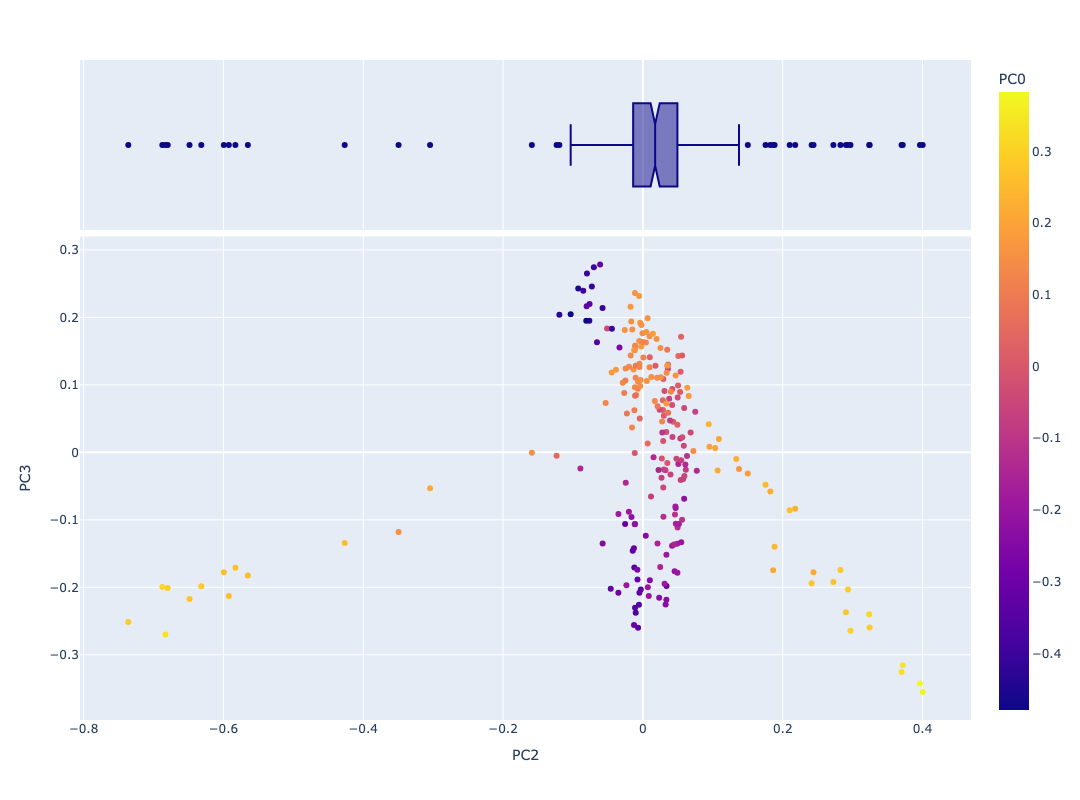

In [17]:
vis_pcs(DCM, 2, 3, label="PC0", hover_name="PC0")

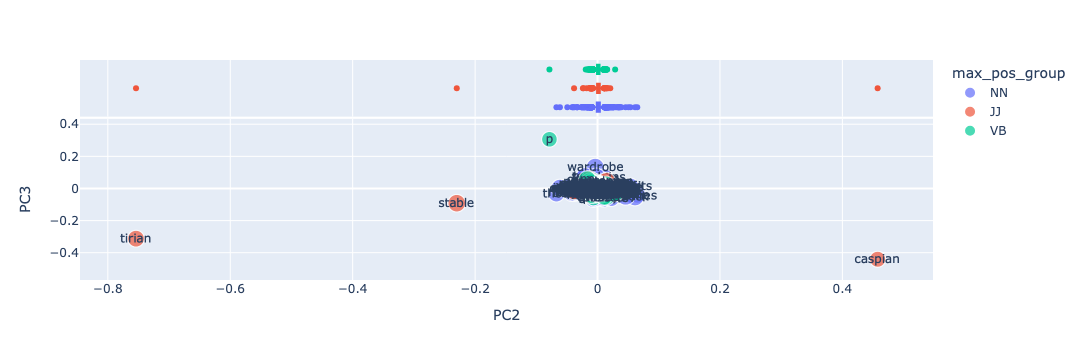

In [18]:
vis_loadings(2, 3)

# LDA

In [19]:
ngram_range = (1, 2)
n_terms = 5000
n_topics = 40
max_iter = 20
n_top_terms = 9

OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

BAG = CHAP

import warnings
warnings.filterwarnings('ignore')

In [20]:
CORPUS

token_str term_str  \
book_id chap_num para_num sent_num token_num                      
1       0        0        0        0              When     when   
                                   1                Mr       mr   
                          1        0             Bilbo    bilbo   
                                   1           Baggins  baggins   
                                   2                of       of   
...                                                ...      ...   
14      16       58       2        5            better   better   
                                   6              than     than   
                                   7               the      the   
                                   8               one      one   
                                   9            before   before   

                                                       pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                            
1       0        0        0        0             ('When', 'WRB')  WRB   
                                   1               ('Mr', 'NNP')  NNP   
                          1        0            ('Bilbo', 'NNP')  NNP   
                                   1          ('Baggins', 'NNP')  NNP   
                                   2                ('of', 'IN')   IN   
...                                                          ...  ...   
14      16       58       2        5           ('better', 'RBR')  RBR   
                                   6              ('than', 'IN')   IN   
                                   7               ('the', 'DT')   DT   
                                   8               ('one', 'CD')   CD   
                                   9            ('before', 'IN')   IN   

                                             pos_group  
book_id chap_num para_num sent_num token_num            
1       0        0        0        0                WR  
                                   1                NN  
                          1        0                NN  
                                   1                NN  
                                   2                IN  
...                                                ...  
14      16       58       2        5                RB  
                                   6                IN  
                                   7                DT  
                                   8                CD  
                                   9                IN  

[1278935 rows x 5 columns]

In [21]:
CORPUS.term_str = CORPUS.term_str.astype(str)
DOCS = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [22]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [23]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [24]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [25]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

# THETA

In [26]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

lda_model = lda_engine.fit_transform(count_model)

THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [27]:
THETA

T00       T01       T02       T03       T04       T05  \
book_id chap_num                                                               
1       0         0.155674  0.000018  0.000018  0.000018  0.000018  0.000018   
        1         0.087935  0.000018  0.000018  0.000018  0.000018  0.000018   
        2         0.073964  0.000017  0.000017  0.000017  0.040208  0.000017   
        3         0.169899  0.000029  0.000029  0.000029  0.045814  0.000029   
        4         0.099433  0.000036  0.000036  0.000036  0.000036  0.000036   
...                    ...       ...       ...       ...       ...       ...   
14      12        0.000070  0.000070  0.000070  0.000070  0.000070  0.000070   
        13        0.000061  0.012579  0.000061  0.000061  0.000061  0.000061   
        14        0.000059  0.000059  0.000059  0.000059  0.000059  0.000059   
        15        0.000067  0.038076  0.000067  0.000067  0.000067  0.000067   
        16        0.000064  0.000064  0.000064  0.000064  0.000064  0.000064   

                       T06       T07       T08       T09  ...       T30  \
book_id chap_num                                          ...             
1       0         0.000018  0.000018  0.000018  0.000018  ...  0.510200   
        1         0.025276  0.000018  0.000018  0.000018  ...  0.565351   
        2         0.091348  0.000017  0.000017  0.000017  ...  0.733710   
        3         0.000029  0.000029  0.000029  0.000029  ...  0.783227   
        4         0.000036  0.000036  0.000036  0.000036  ...  0.686907   
...                    ...       ...       ...       ...  ...       ...   
14      12        0.000070  0.000070  0.000070  0.000070  ...  0.145841   
        13        0.000061  0.000061  0.000061  0.000061  ...  0.141826   
        14        0.000059  0.000059  0.000059  0.000059  ...  0.000059   
        15        0.000067  0.000067  0.000067  0.000067  ...  0.000067   
        16        0.082645  0.000064  0.000064  0.000064  ...  0.086130   

                       T31       T32       T33       T34       T35       T36  \
book_id chap_num                                                               
1       0         0.000018  0.024228  0.000018  0.000018  0.000018  0.000018   
        1         0.000018  0.011637  0.000018  0.000018  0.000018  0.000018   
        2         0.000017  0.000017  0.000017  0.000017  0.000017  0.000017   
        3         0.000029  0.000029  0.000029  0.000029  0.000029  0.000029   
        4         0.000036  0.000036  0.000036  0.000036  0.000036  0.000036   
...                    ...       ...       ...       ...       ...       ...   
14      12        0.000070  0.000070  0.000070  0.000070  0.018331  0.000070   
        13        0.000061  0.000061  0.000061  0.000061  0.000061  0.000061   
        14        0.000059  0.000059  0.000059  0.000059  0.000059  0.000059   
        15        0.000067  0.000067  0.000067  0.000067  0.000067  0.000067   
        16        0.000064  0.000064  0.000064  0.000064  0.014976  0.000064   

                       T37       T38       T39  
book_id chap_num                                
1       0         0.000018  0.000018  0.000018  
        1         0.000018  0.000018  0.007952  
        2         0.000017  0.000017  0.000017  
        3         0.000029  0.000029  0.000029  
        4         0.000036  0.000036  0.000036  
...                    ...       ...       ...  
14      12        0.000070  0.000070  0.018637  
        13        0.000061  0.000061  0.000061  
        14        0.000059  0.000059  0.000059  
        15        0.000067  0.000067  0.000067  
        16        0.000064  0.000064  0.000064  

[232 rows x 40 columns]

# PHI

In [28]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [29]:
PHI

term_str      abode    absence      abyss   accident    accord    account  \
topic_id                                                                    
T00        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T01        0.025000   0.025000   0.025000   1.025000  0.025000   0.025000   
T02        0.025000   1.005281   0.025000   0.025000  0.025000   0.025000   
T03        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T04        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T05        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T06        0.564669   0.025000   0.025000   0.025000  0.025000   0.025000   
T07        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T08        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T09        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T10        0.025000   0.025000   0.025000   1.302632  0.025000   2.459273   
T11        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T12        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T13        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T14        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T15        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T16        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T17        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T18        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T19        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T20        2.324045   0.025000   0.025000   0.025000  1.246600   0.025000   
T21        0.025000   0.025000   0.025000   0.025000  0.025000   1.477511   
T22        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T23        8.895396   0.025000   0.025000   0.025000  0.025000   0.025000   
T24       20.403570   0.025000  13.087955   0.025000  0.025000   9.020683   
T25        0.025000   0.025000   0.025000   4.219878  0.025000   1.978053   
T26        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T27        0.025000   3.157466   4.962045   0.025000  0.025000   0.025000   
T28       19.759586   0.025000   0.025000   1.042857  4.038905  68.161384   
T29        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T30        0.025000   2.421790   0.025000  14.534634  3.561553  28.880285   
T31        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T32        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T33        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T34        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T35        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T36        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T37        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T38        0.025000   0.025000   0.025000   0.025000  0.025000   0.025000   
T39       11.202734  12.515463   0.025000   0.025000  2.252942   8.197810   

term_str   accounts     acres       act   action  ...  youngster  youngsters  \
topic_id                                          ...                          
T00        9.721527  0.025000  0.025000  0.02500  ...    0.02500       0.025   
T01        0.025000  1.025000  0.025000  0.02500  ...    0.02500       0.025   
T02        0.025000  0.025000  0.025000  0.02500  ...    0.02500       1.025   
T03        0.025000  0.025000  0.025000  0.02500  ...    0.02500       0.025   
T04        0.025000  0.025000  0.025000  0.02500  ...    1.57309       0.025   
T05        0.025000  0.025000  0.025000  0.02500  ...    0.02500       0.025   
T06        0.025000  0.025000  0.025000  0.02500  ...    0.02500       0.025   
T07        0.025000  0.025000  0.025000  0.02

# TOPICS

In [30]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [31]:
TOPICS

top_terms  doc_weight_sum  \
topic_id                                                                      
T00       nan hobbits folk time ruffians things trouble ...        3.770195   
T01       nan moment night girls children thing end time...        2.329091   
T02       slave islands boat courtyard man nan village m...        0.841550   
T03       road chasm lamps horses minutes water gnomes p...        0.387999   
T04       nan trees ents time horse way hobbits wood things        6.869866   
T05       snow earth people elves time stone days things...        1.843291   
T06       trees earth world things light elves stars son...        9.171697   
T07       abode races rail raid rags rage rag raft radiance        0.035544   
T08       abode races rail raid rags rage rag raft radiance        0.035544   
T09       abode races rail raid rags rage rag raft radiance        0.035544   
T10       nan time door things thing moment course world...       38.488261   
T11       stars sky sea light creatures world grass shap...        0.881327   
T12       abode races rail raid rags rage rag raft radiance        0.035544   
T13       dragon town lake men wealth people shores spar...        0.632362   
T14       nan things time cliff sort door edge voice school        1.518676   
T15       abode races rail raid rags rage rag raft radiance        0.035544   
T16       abode races rail raid rags rage rag raft radiance        0.035544   
T17       nan sentry sword moment night thing whisper ma...        1.056003   
T18       horse ships road tears knights nan host cloud ...        0.521396   
T19       nan boat voices island people spell shore stor...        1.239490   
T20       music things world draft text time tongue pass...        1.381891   
T21       nan time moment dwarf face stone course snow s...        9.743490   
T22       abode races rail raid rags rage rag raft radiance        0.035544   
T23       land people mountains east sea west waters nor...        1.557193   
T24       time heart son people elves power words nan house       22.304173   
T25         nan voice moment face time head world thing man       30.473334   
T26       horse hills wound shoulder trolls troll countr...        0.247294   
T27               nan men man king war son days eyes battle       15.233414   
T28           elves tale nan world sea time story folk days       10.762432   
T29       master voice way horse world mouth oliphaunts ...        1.168017   
T30           nan way time eyes night water road hand light       59.363820   
T31       trolls pocket breakfast mutton pony dwarves di...        0.397191   
T32       dwarves gold elves king treasure hall river dw...        2.383122   
T33       heaven vessels vessel vigil glass crowns wicke...        0.103958   
T34       abode races rail raid rags rage rag raft radiance        0.035544   
T35          ship sea water boat deck day voyage board wind        3.092504   
T36       abode races rail raid rags rage rag raft radiance        0.035544   
T37       nan eyes people lists combat girls army water ...        1.579330   
T38       nan skin lion waterfall thing horse river star...        1.355079   
T39         tale folk story men woods thou king place heart        0.982658   

          term_freq  
topic_id             
T00        0.018744  
T01        0.004547  
T02        0.002362  
T03        0.001385  
T04        0.027024  
T05        0.006794  
T06        0.037866  
T07        0.000634  
T08        0.000634  
T09        0.000634  
T10        0.090719  
T11        0.002467  
T12        0.000634  
T13        0.002650  
T14        0.004435  
T15        0.000634  
T16        0.000634  
T17        0.002531  
T18        0.002296  
T19        0.002985  
T20        0.006616  
T21        0.020625  
T22        0.000634  
T23        0.004841  
T24        0.126901  
T25        0.073519  
T26        0.002118  
T27        0.080856  
T28        0.116558  
T29        0.003734  
T30        0.301673  
T31  

# PCA Visualizations

In [ ]:
PHI_DCM, LOADINGS = create_pca(PHI)

In [ ]:
vis_pcs(PHI_DCM, 0, 1, label="PC0", hover_name="PC0")

In [ ]:
vis_loadings(0, 1)

# Sentiment Analysis
### VOCAB_SENT

In [34]:
salex_csv = 'lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

V = pd.concat([VOCAB_imp.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
V.head()

n  n_chars             p          i max_pos max_pos_group  stop  \
term_str                                                                        
abandon      19        7  1.485611e-05  16.038584      VB            VB     0   
abandoned    34        9  2.658462e-05  15.199049     VBN            VB     0   
abandonment   2       11  1.563801e-06  19.286512      NN            NN     0   
abhor         1        5  7.819006e-07  20.286512      NN            NN     0   
abominable    9       10  7.037105e-06  17.116587      JJ            JJ     0   

            porter_stem      dfidf  anger  anticipation  disgust  fear  joy  \
term_str                                                                      
abandon         abandon  56.708765      0             0        0     1    0   
abandoned       abandon  64.098809      1             0        0     1    0   
abandonment     abandon  13.715962      1             0        0     1    0   
abhor             abhor   7.857981      1             0        1     1    0   
abominable       abomin  42.192504      0             0        1     1    0   

             negative  positive  sadness  surprise  trust  sentiment  
term_str                                                              
abandon             1         0        1         0      0         -1  
abandoned           1         0        1         0      0         -1  
abandonment         1         0        1         1      0         -1  
abhor               1         0        0         0      0         -1  
abominable          1         0        0         0      0         -1

### BOW_SENT

In [35]:
B = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [36]:
B

n     tfidf max_pos  anger  anticipation  \
book_id chap_num term_str                                                
1       0        abominable   1  0.010395      JJ    0.0           0.0   
                 abundant     1  0.015206      JJ    0.0           0.0   
                 accident     1  0.008761      NN    0.0           0.0   
                 accusing     1  0.013909     VBG    1.0           0.0   
                 admirable    1  0.011199      JJ    0.0           0.0   
...                          ..       ...     ...    ...           ...   
14      16       white        3  0.005284      JJ    0.0           1.0   
                 wild         2  0.009480      JJ    0.0           0.0   
                 wonderful    2  0.019331      JJ    0.0           0.0   
                 wonderfully  1  0.021829      RB    0.0           0.0   
                 young        1  0.005594      JJ    0.0           1.0   

                              disgust  fear  joy  sadness  surprise  trust  \
book_id chap_num term_str                                                    
1       0        abominable       1.0   1.0  0.0      0.0       0.0    0.0   
                 abundant         0.0   0.0  1.0      0.0       0.0    0.0   
                 accident         0.0   1.0  0.0      1.0       1.0    0.0   
                 accusing         0.0   1.0  0.0      0.0       0.0    0.0   
                 admirable        0.0   0.0  1.0      0.0       0.0    1.0   
...                               ...   ...  ...      ...       ...    ...   
14      16       white            0.0   0.0  1.0      0.0       0.0    1.0   
                 wild             0.0   0.0  0.0      0.0       1.0    0.0   
                 wonderful        0.0   0.0  1.0      0.0       1.0    1.0   
                 wonderfully      0.0   0.0  1.0      0.0       1.0    0.0   
                 young            0.0   0.0  1.0      0.0       1.0    0.0   

                              sentiment  
book_id chap_num term_str                
1       0        abominable        -1.0  
                 abundant           1.0  
                 accident          -1.0  
                 accusing          -1.0  
                 admirable          1.0  
...                                 ...  
14      16       white              1.0  
                 wild              -1.0  
                 wonderful          1.0  
                 wonderfully        1.0  
                 young              1.0  

[32152 rows x 12 columns]

### DOC_SENT

In [90]:
BAG = OHCO[:1] # CHAPS
EMO_CHAPS = B.groupby(['book_id', 'chap_num'])[emo_cols].mean()

In [97]:
LIB

book_title     book_author  date  book_len
book_id                                                                       
1                       Fellowship of the Ring  J.R.R. Tolkien  1954  182850.0
2                               The Two Towers  J.R.R. Tolkien  1954  160213.0
3                           Return of the King  J.R.R. Tolkien  1955  138585.0
4                                   The Hobbit  J.R.R. Tolkien  1937   97251.0
5               The Book of Lost Tales, Part 1  J.R.R. Tolkien  1983  108638.0
6               The Book of Lost Tales, Part 2  J.R.R. Tolkien  1984  158964.0
7                             The Silmarillion  J.R.R. Tolkien  1977  102262.0
8        The Lion, the Witch, and the Wardrobe      C.S. Lewis  1950   38697.0
9        Prince Caspian: The Return to Narnia       C.S. Lewis  1951   46862.0
10              The Voyage of the Dawn Treader      C.S. Lewis  1952   54270.0
11                            The Silver Chair      C.S. Lewis  1953   53253.0
12                       The Horse and His Boy      C.S. Lewis  1954   49930.0
13                       The Magician's Nephew      C.S. Lewis  1955   42304.0
14                             The Last Battle      C.S. Lewis  1956   44856.0

In [98]:
FELLOWSHIP_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(1))
TOWERS_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(2))
KING_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(3))
HOBBIT_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(4))
TALES1_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(5))
TALES2_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(6))
SILMARILLION_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(7))

LION_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(8))
CASPIAN_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(9))
DAWN_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0:'value','level_2':'emo'}).query("book_id == {}".format(10))

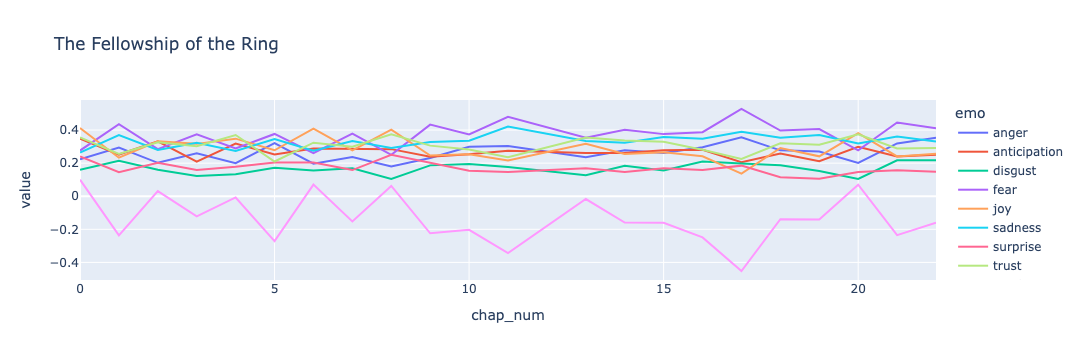

In [96]:
px.line(FELLOWSHIP_chaps_thin, x= 'chap_num', y='value', color='emo', title="The Fellowship of the Ring")

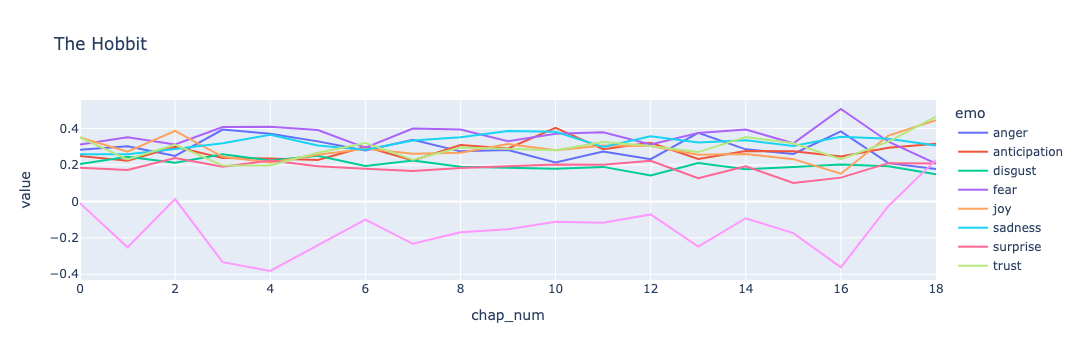

In [95]:
px.line(HOBBIT_chaps_thin, x= 'chap_num', y='value', color='emo', title="The Hobbit")

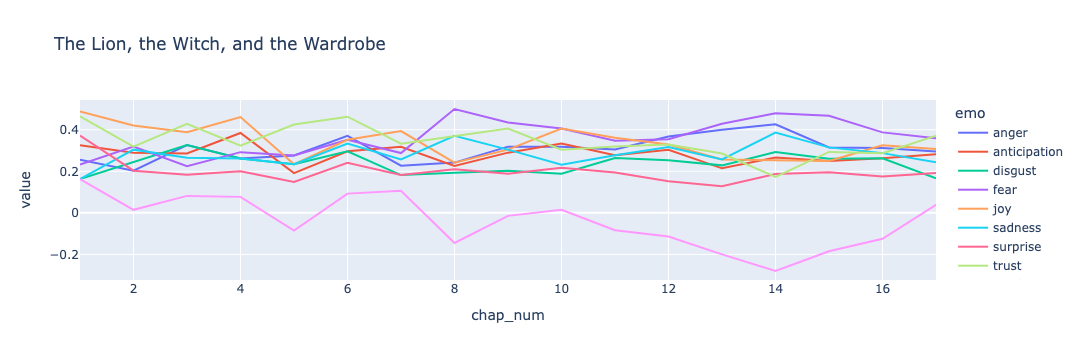

In [99]:
px.line(LION_chaps_thin, x= 'chap_num', y='value', color='emo', title="The Lion, the Witch, and the Wardrobe")

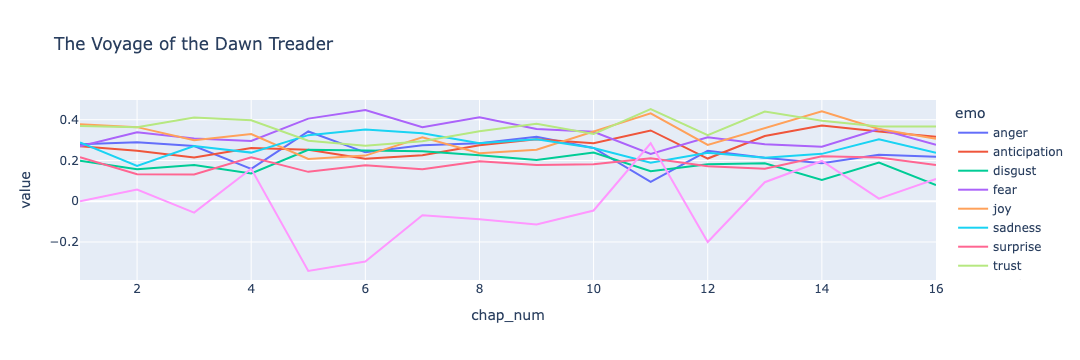

In [101]:
px.line(DAWN_chaps_thin, x= 'chap_num', y='value', color='emo', title="The Voyage of the Dawn Treader")

In [41]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

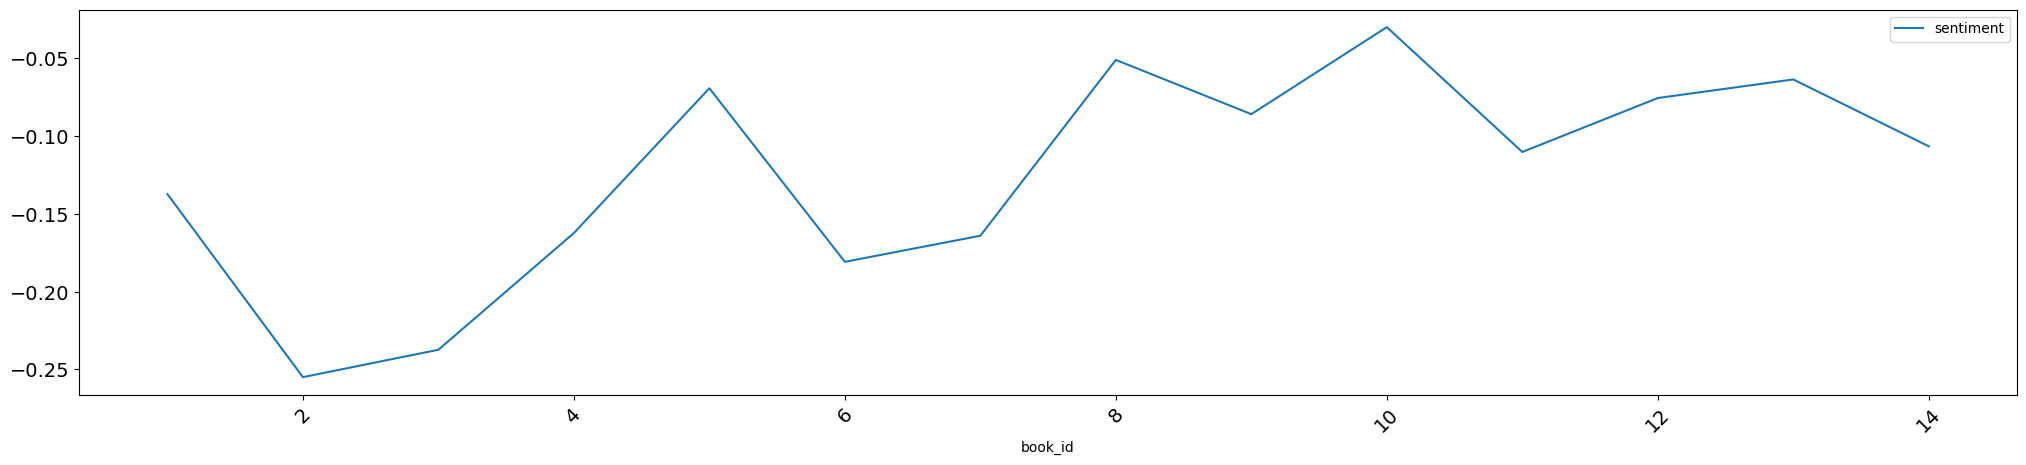

In [66]:
plot_sentiments(EMO_CHAPS)

# Word Embedding

In [102]:
VOCAB = VOCAB_imp
TOKENS = CORPUS

# word2vec parameters
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [103]:
docs = TOKENS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs
vocab = Dictionary(docs)

In [104]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [105]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [106]:
WV

0         1         2         3         4         5    \
term_str                                                               
1         0.049405 -0.064630 -0.066280  0.072353  0.066073 -0.122670   
10        0.025358 -0.022749 -0.017215  0.037333  0.005005 -0.042819   
2         0.035220 -0.027978 -0.024745  0.043776  0.003541 -0.056312   
3         0.046139 -0.024674 -0.022652  0.070204 -0.011852 -0.074966   
4         0.032796 -0.016552 -0.023089  0.049502  0.000641 -0.057165   
...            ...       ...       ...       ...       ...       ...   
youve     0.083693 -0.083495 -0.102457  0.072457  0.040517 -0.174137   
ælfwine   0.021155 -0.006422 -0.004968  0.026473 -0.004499 -0.032457   
éomer     0.104385 -0.045644 -0.041121  0.119554  0.053532 -0.122564   
éowyn     0.004798 -0.004944 -0.003915  0.002411  0.001780 -0.003513   
úrin     -0.004234  0.002693  0.004573 -0.000437  0.003625 -0.004109   

               6         7         8         9    ...       190       191  \
term_str                                          ...                       
1         0.107763  0.230136 -0.088750  0.014989  ...  0.048274 -0.017562   
10        0.019526  0.082283 -0.039516  0.019925  ...  0.034018 -0.002530   
2         0.034983  0.111622 -0.039811  0.027401  ...  0.038274 -0.001205   
3         0.029884  0.133531 -0.054757  0.047471  ...  0.056014 -0.014579   
4         0.021944  0.104876 -0.044559  0.027878  ...  0.045729 -0.007128   
...            ...       ...       ...       ...  ...       ...       ...   
youve     0.060448  0.271856 -0.081962  0.025280  ...  0.102335  0.002669   
ælfwine   0.006616  0.054794 -0.017319  0.006217  ...  0.021820 -0.005365   
éomer     0.137659  0.244916 -0.131152  0.080797  ...  0.038761  0.017218   
éowyn     0.003867  0.013418 -0.008588 -0.000713  ...  0.002696 -0.003293   
úrin      0.001173  0.002914 -0.002024  0.001934  ... -0.003683  0.001838   

               192       193       194       195       196       197  \
term_str                                                               
1         0.042455 -0.137402  0.095122  0.062792  0.049710 -0.100280   
10        0.000027 -0.064371  0.048402  0.032836  0.025282 -0.038546   
2         0.013261 -0.090999  0.063248  0.035990  0.026718 -0.045573   
3        -0.001518 -0.142529  0.106197  0.075184  0.042539 -0.065027   
4         0.000371 -0.105990  0.083172  0.061891  0.037752 -0.060839   
...            ...       ...       ...       ...       ...       ...   
youve     0.048780 -0.210376  0.135863  0.123889  0.073671 -0.129564   
ælfwine   0.006419 -0.050484  0.038839  0.027418  0.011684 -0.018920   
éomer     0.037772 -0.189281  0.141194  0.047201  0.019176 -0.064756   
éowyn     0.002135 -0.010315  0.004178  0.004920 -0.000193 -0.001688   
úrin     -0.000330 -0.002409 -0.001398 -0.002059  0.001307 -0.002234   

               198       199  
term_str                      
1         0.010742 -0.053227  
10       -0.025077 -0.045545  
2        -0.040151 -0.055287  
3        -0.086757 -0.086555  
4        -0.063724 -0.069197  
...            ...       ...  
youve    -0.041401 -0.084318  
ælfwine  -0.022397 -0.024295  
éomer    -0.071450 -0.049016  
éowyn    -0.009604 -0.010920  
úrin     -0.004993 -0.003903  

[2123 rows x 200 columns]

# TSNE Plot

In [107]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(WV.to_numpy())
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [108]:
X = TSNE.join(VOCAB, how='left')

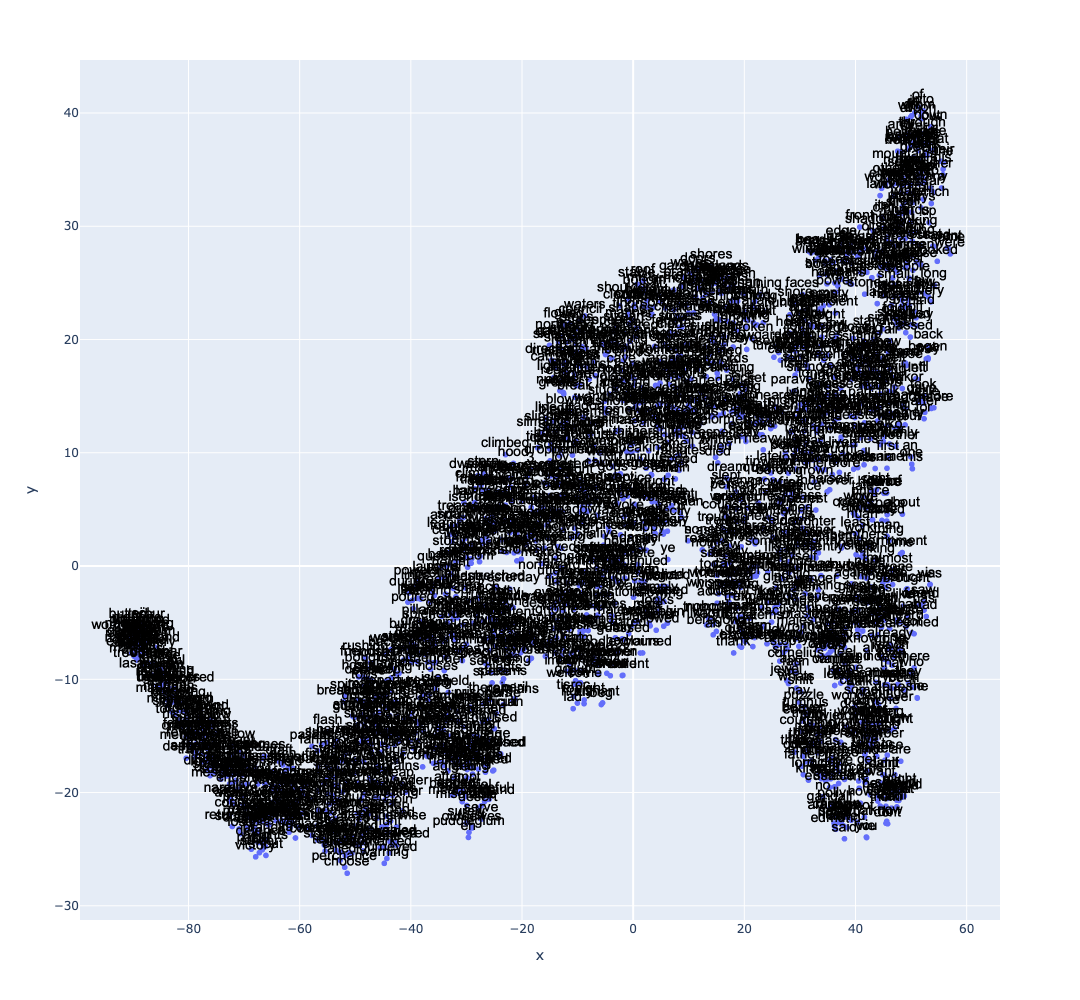

In [109]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           # color='pos_max', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Riffs

### Riff 1

In [110]:
def top_books_for_term(term_str):
    X = BOW.join(LIB).query(f"term_str == '{term_str}'").groupby(['book_author','book_title'])\
        .agg({'tfidf':'mean', 'n':'sum'})
    return px.scatter(X.reset_index(), 'n','tfidf', color='book_author',
                      hover_name='book_title', 
                      height=500, width=600, title=f"{term_str}")

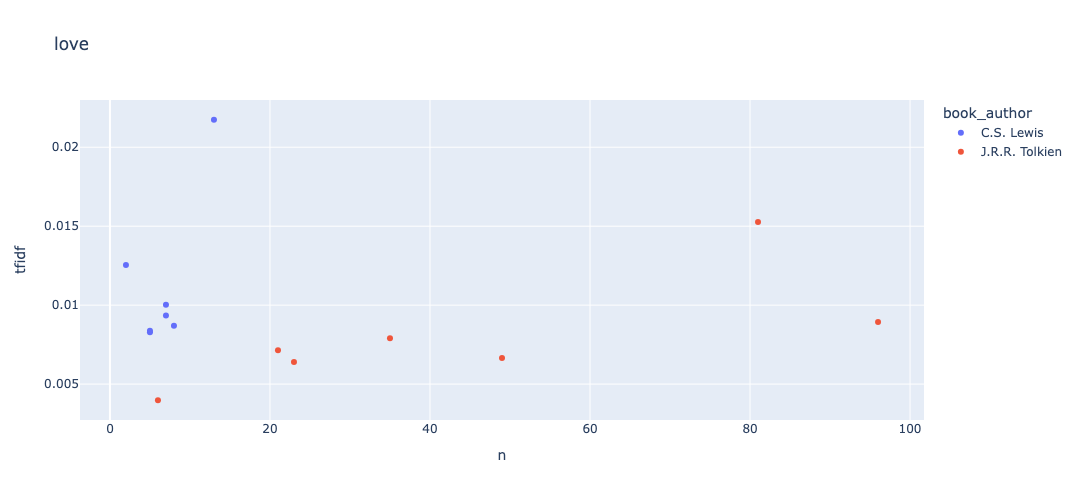

In [111]:
top_books_for_term("love")

### Riff 2

In [112]:
TFIDF.groupby('book_id').mean()

term_str     watch     swift      bare    raised    listen      sign  \
book_id                                                                
1         0.005722  0.003412  0.002731  0.001659  0.002586  0.006381   
2         0.006711  0.005953  0.004263  0.003855  0.001815  0.004150   
3         0.002099  0.004962  0.002475  0.003294  0.002488  0.003201   
4         0.003013  0.003083  0.001058  0.000437  0.003051  0.004663   
5         0.000428  0.000669  0.002058  0.001953  0.001260  0.000383   
6         0.001671  0.002764  0.001276  0.001139  0.000529  0.002239   
7         0.003350  0.003599  0.001312  0.002550  0.000563  0.001227   
8         0.002161  0.000000  0.001063  0.003773  0.002425  0.001813   
9         0.003234  0.001206  0.001485  0.003051  0.003655  0.001288   
10        0.003225  0.000000  0.002488  0.002751  0.001136  0.001954   
11        0.001152  0.000000  0.006172  0.003579  0.004192  0.005381   
12        0.002238  0.003346  0.008316  0.000575  0.002334  0.003002   
13        0.003748  0.003354  0.003642  0.003106  0.005516  0.002056   
14        0.001932  0.000000  0.001000  0.006277  0.006943  0.002321   

term_str   enemies      wise    likely   trouble  ...  supplies   trained  \
book_id                                           ...                       
1         0.002215  0.005550  0.002634  0.005492  ...  0.000369  0.000000   
2         0.005589  0.005422  0.003592  0.004323  ...  0.000288  0.000505   
3         0.003611  0.001873  0.002023  0.007152  ...  0.000000  0.001399   
4         0.001693  0.003390  0.003679  0.006196  ...  0.004678  0.000000   
5         0.000444  0.002181  0.000160  0.000517  ...  0.000000  0.000000   
6         0.000378  0.002674  0.001173  0.000360  ...  0.000000  0.000000   
7         0.002310  0.005026  0.000349  0.000638  ...  0.000000  0.000529   
8         0.004861  0.000000  0.001437  0.001636  ...  0.000000  0.000000   
9         0.005070  0.005491  0.008401  0.002764  ...  0.000000  0.000000   
10        0.001120  0.000533  0.003101  0.003097  ...  0.001697  0.002104   
11        0.004540  0.002841  0.008135  0.000476  ...  0.000000  0.000000   
12        0.002552  0.000847  0.007756  0.002273  ...  0.000000  0.003647   
13        0.003631  0.001326  0.001511  0.002119  ...  0.000000  0.002980   
14        0.005856  0.001908  0.003872  0.001799  ...  0.000000  0.000000   

term_str    fathom   escapes       vow  impatience   shocked     fares  \
book_id                                                                  
1         0.000000  0.000000  0.000327    0.000000  0.000415  0.000000   
2         0.001515  0.000952  0.000466    0.000614  0.000000  0.000000   
3         0.000000  0.000000  0.000519    0.000309  0.000476  0.000000   
4         0.000000  0.001502  0.000000    0.000425  0.000000  0.000000   
5         0.001212  0.000000  0.000000    0.000000  0.000000  0.002514   
6         0.000255  0.003293  0.000000    0.000000  0.000000  0.003779   
7         0.000000  0.000000  0.003512    0.003141  0.000000  0.000000   
8         0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   
9         0.000000  0.000000  0.000000    0.000000  0.002631  0.000000   
10        0.000000  0.001879  0.000000    0.003685  0.000000  0.000000   
11        0.004122  0.000000  0.000000    0.000000  0.000000  0.000000   
12        0.000000  0.000000  0.000000    0.000000  0.004565  0.000000   
13        0.000000  0.000000  0.000000    0.003915  0.006447  0.000000   
14        0.000000  0.000000  0.000000    0.000000  0.000000  0.000000   

term_str  anchored    joints  
book_id                       
1         0.000000  0.001345  
2         0.000000  0.001189  
3         0.000764  0.000000  
4         0.000000  0.000000  
5         0.001735  0.000000  
6         0.000348  0.000000  
7         0.001113  0.000247  
8         0.000000  0.000000  
9         0.000000  0.000000  
10        0.001315  0.001315  
11        0.000000  0.003628  
12        0.000000  0.0000

In [113]:
# corr_type = 'pearson'
corr_type = 'kendall'
# corr_type = 'spearman'

CORR_MATRIX = TFIDF.groupby('book_id').mean().T.corr(corr_type)

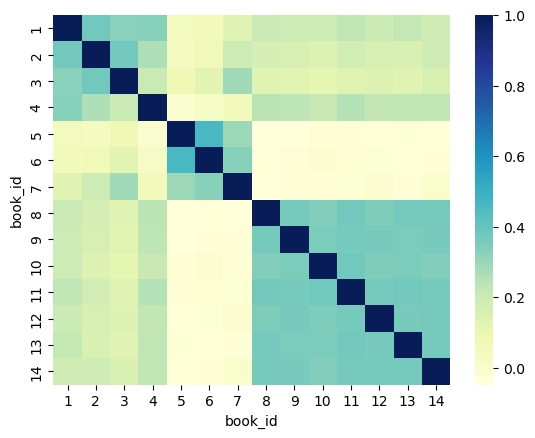

In [114]:
sns.heatmap(CORR_MATRIX, cmap=colors);